<h1 style="font-size:30px;">Homography and Image Warping</h1> 

In this notebook we will take a look at a concrete example of how homography and image warping can be used to align a photo of a scanned form to a template of the form. This process is generally referred to as image alignment or image registration and has numerous applications.

The multi-step process includes the following steps:

* Feature/keypoint extraction between an image and a reference image
* Keypoint matching
* Homography
* Image warping


<img src='./visuals/Feature_Image_12_04.png'>

# 1. Geometric Transformations: Review of Theory


<img src='./visuals/motion-models.jpg'>





## 1.1 Homography
1. A **Homography** transforms a square to an arbitrary quadralateral. 
2. Images of two planes are related by a **Homography**
3. We need a minimum of **4 corresponding points** to estimate a Homography

<img src='./visuals/homography-example.jpg' width='900'>

# 2. Implementation

In [62]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 2.1 Read and Display Images of Scanned Form and Template

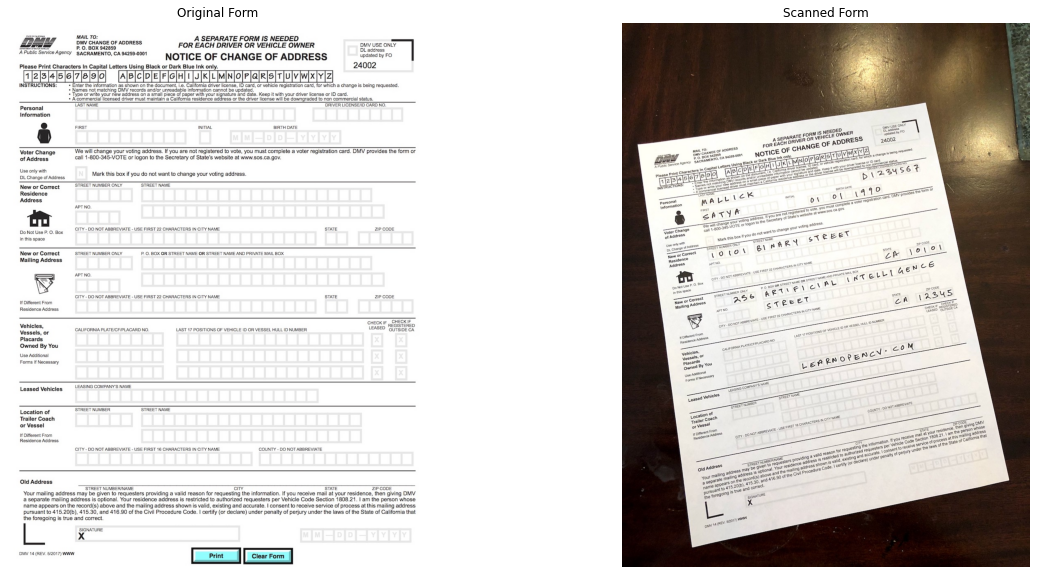

In [63]:
# Read reference image of the form.
img_form = 'form.jpg'
img_form = cv2.imread(img_form, cv2.IMREAD_COLOR)

# Read image of the scanned form to be aligned.
img_scan = "scanned-form.jpg"
img_scan = cv2.imread(img_scan, cv2.IMREAD_COLOR)

# Display the images. 
plt.figure(figsize=[20, 10]); 
plt.subplot(121); plt.axis('off'); plt.imshow(img_form[:, :, ::-1]); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(img_scan[:, :, ::-1]); plt.title("Scanned Form");

## 2.2 Find keypoints in Both Images

The ORB class in OpenCV implements the ORB (oriented BRIEF) keypoint detector and descriptor extractor. Think of keypoints as points within each image that are associated with well defined corners that are stable under image transformations. Each keypoint has an associated feature descriptor vector. Keypoints and Descriptors can be computed using `detectAndCompute()`. The keypoints themselevs can be drawn on the image using a function called `drawKeypoints()`.

## ORB Class
<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font color="green">Function Syntax</font>
```python
retval = cv2.ORB_create([, nfeatures[, scaleFactor[, nlevels[, edgeThreshold[, firstLevel[, WTA_K[, scoreType[, patchSize[, fastThreshold]]]]]]]]])
```

### <font color="green">OpenCV Documentation</font>

[**`ORB Class Reference`**](https://docs.opencv.org/4.5.2/db/d95/classcv_1_1ORB.html)

## Keypoints and Descriptor  Extraction

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font color="green">Function Syntax</font>
```python
keypoints, descriptors = cv.Feature2D.detectAndCompute(image, mask[, descriptors[, useProvidedKeypoints]])


```
The function has **2 required argument**:

1. `image`: Input image.
2. `mask`: Input mask (but this can be specified as `None`).

### <font color="green">OpenCV Documentation</font>


[**`detectAndCompute()`**](https://docs.opencv.org/4.5.2/d0/d13/classcv_1_1Feature2D.html#a8be0d1c20b08eb867184b8d74c15a677)


## Drawing Keypoints

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font color="green">Function Syntax</font>
```python
outImage = cv2.drawKeypoints(image, keypoints, outImage[, color[, flags]])
```
The function has **3 required argument**:

1. `image`: Source image.
2. `keypoints`: Keypoints from the source image.
3. `outImage`: Can be specified as `None` if using return value from function.

### <font color="green">OpenCV Documentation</font>


[**`drawKeypoints()`**](https://docs.opencv.org/4.5.2/d4/d5d/group__features2d__draw.html#ga5d2bafe8c1c45289bc3403a40fb88920)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

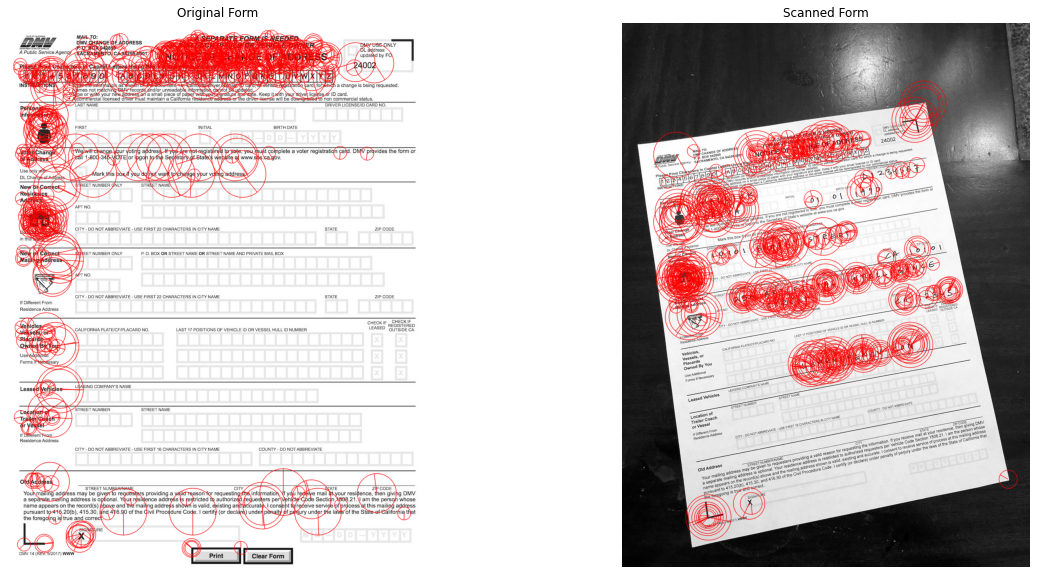

In [64]:
# Convert images to grayscale.
img_form_gray = cv2.cvtColor(img_form, cv2.COLOR_BGR2GRAY)
img_scan_gray = cv2.cvtColor(img_scan, cv2.COLOR_BGR2GRAY)
  
# Detect ORB features and compute descriptors.
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(img_form_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(img_scan_gray, None)

# Draw the keypoints in both images.
img_form_keypoints = cv2.drawKeypoints(img_form_gray, keypoints1, None, color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_scan_keypoints = cv2.drawKeypoints(img_scan_gray, keypoints2, None, color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the images with the kaypoints.
plt.figure(figsize=[20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(img_form_keypoints); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(img_scan_keypoints); plt.title("Scanned Form");

### <font style="color:rgb(50,120,230)">Examine a keypoint and its associated descriptor</font>

In [65]:
idx = 0
print(img_form_gray.shape)
print ("")
print ("keypoint angle: ", keypoints1[idx].angle)
print ("keypoint size:  ", keypoints1[idx].size)
print ("keypoint x:     ", keypoints1[idx].pt[0])
print ("keypoint y:     ", keypoints1[idx].pt[1])
print ("")
print (descriptors1[idx])
print ("")


print ("")
print ("keypoint angle: ", keypoints2[idx].angle)
print ("keypoint size:  ", keypoints2[idx].size)
print ("keypoint x:     ", keypoints2[idx].pt[0])
print ("keypoint y:     ", keypoints2[idx].pt[1])
print ("")
print (descriptors2[idx])
print ("")

(1293, 1000)

keypoint angle:  111.73631286621094
keypoint size:   31.0
keypoint x:      597.0
keypoint y:      57.0

[ 98  24 177 219 252 165 170   8  14   9  89 112 180 254 108  64 204  59
  51 145 147  10 203 243  13  52 186 234 152  11  48 179]


keypoint angle:  138.33984375
keypoint size:   31.0
keypoint x:      132.0
keypoint y:      695.0

[ 34 104 226 177 103 195 188  70  94 166  80 163   8 140 119   8 251  57
 147 145 196 182   4 202  52  92 159 163 213 124 117 143]



### <font style="color:rgb(50,120,230)">Plot two random descriptors</font>

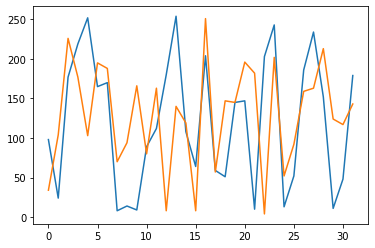

In [66]:
d1 = descriptors1[0]
d2 = descriptors2[0]
plt.plot(d1)
plt.plot(d2);

## 3.3 Match Keypoints in the Two Images

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

**`DescriptorMatcher_create()`** Creates a descriptor matcher of a given type with the default parameters (using default constructor).

### <font color="green">Function Syntax </font>
``` python
retval = cv2.DescriptorMatcher_create(descriptorMatcherType)
```

The function has **1 required argument**:

1. `descriptorMatcherType`: Descriptor matcher type.

### <font color="green">OpenCV Documentation</font>


[**`DescriptorMatcher Class Reference`**](https://docs.opencv.org/4.5.2/db/d39/classcv_1_1DescriptorMatcher.html)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font color="green">Function Syntax </font>
``` python
matches = cv.DescriptorMatcher.match(queryDescriptors, trainDescriptors[, mask])
```

The function has **2 required argument**:


1. `queryDescriptors`: Query set of descriptors.
2. `trainDescriptors`: Train set of descriptors. This set is not added to the train descriptors collection stored in the class object.


### <font color="green">OpenCV Documentation</font>

[**`match()`**](https://docs.opencv.org/4.5.2/db/d39/classcv_1_1DescriptorMatcher.html#a0f046f47b68ec7074391e1e85c750cba))

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

In [67]:
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

matches = matcher.match(descriptors1, descriptors2, None)
  
# Sort matches by score.
matches.sort(key=lambda x: x.distance, reverse=False)

# Retain only the top 10% of matches.
numGoodMatches = int(len(matches) * 0.10)
matches = matches[:numGoodMatches]

### <font style="color:rgb(50,120,230)">Print BEST keypoint and descriptor vector from each image</font>

In [68]:
idx = 0

qdx = matches[idx].queryIdx
tdx = matches[idx].trainIdx

print ("")
print ("keypoint angle: ", keypoints1[qdx].angle)
print ("keypoint size:  ", keypoints1[qdx].size)
print ("keypoint x:     ", keypoints1[qdx].pt[0])
print ("keypoint y:     ", keypoints1[qdx].pt[1])
print ("")
print ("descriptor1[ 0:15]: ", descriptors1[qdx][0:15])  # Print first 16 elements of descriptor.
print ("descriptor1[16:32]: ", descriptors1[qdx][16:31]) # Print next 16 elements of descriptor.
print ("")

print ("")
print ("keypoint angle: ", keypoints2[tdx].angle)
print ("keypoint size:  ", keypoints2[tdx].size)
print ("keypoint x:     ", keypoints2[tdx].pt[0])
print ("keypoint y:     ", keypoints2[tdx].pt[1])
print ("")
print ("descriptor1[ 0:15]: ", descriptors2[tdx][0:15])  # Print first 16 elements of descriptor,
print ("descriptor1[16:32]: ", descriptors2[tdx][16:31]) # Print next 16 elements of descriptor.
print ("")


keypoint angle:  283.39520263671875
keypoint size:   64.28160858154297
keypoint x:      89.16481018066406
keypoint y:      238.4640350341797

descriptor1[ 0:15]:  [ 25 207  66 172 148 147 207 245  68   4  92 230  97  99 179]
descriptor1[16:32]:  [ 88 106   6 238 201 186  36 189 168 229 166 128  63 154 248]


keypoint angle:  278.00213623046875
keypoint size:   44.6400032043457
keypoint x:      139.6800079345703
keypoint y:      460.8000183105469

descriptor1[ 0:15]:  [ 57 207  66 174 148 147 207 245  68   4  92 230 113 225 179]
descriptor1[16:32]:  [124 106   6 238 201 186  36 189 224 205 166 128  63 186 248]



### <font style="color:rgb(50,120,230)">Plot the descriptors for the BEST keypoint match</font>

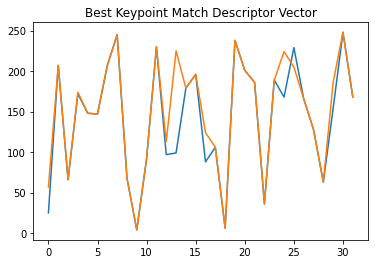

In [69]:
idx = 0 # Best match.
d1 = descriptors1[matches[idx].queryIdx]
d2 = descriptors2[matches[idx].trainIdx]
plt.plot(d1)
plt.plot(d2)
plt.title("Best Keypoint Match Descriptor Vector");

### <font style="color:rgb(50,120,230)">Draw the matches of the corresponding keypoints</font>

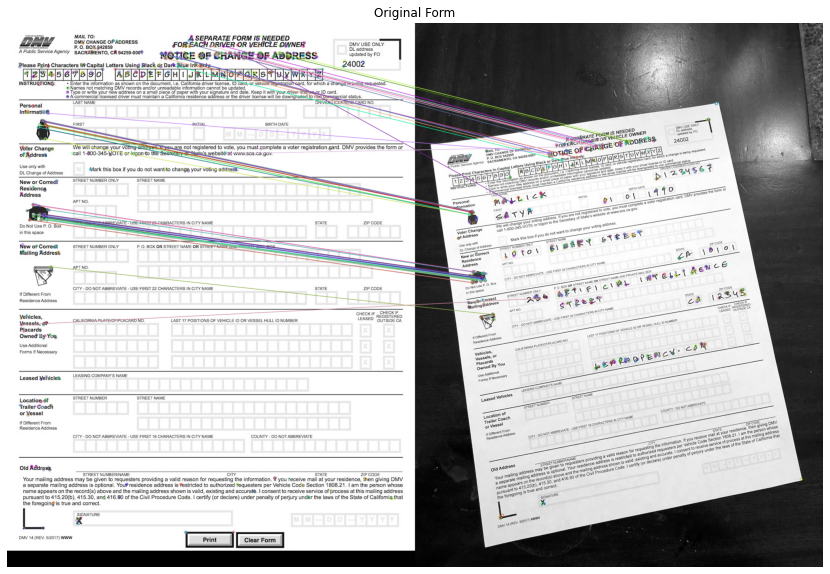

In [70]:
# Draw top matches
im_matches = cv2.drawMatches(img_form_gray, keypoints1, img_scan_gray, keypoints2, matches, None)

plt.figure(figsize=[40,10])
plt.imshow(im_matches); plt.axis('off'); plt.title("Original Form");


## 2.4 Find the Homography



In [71]:
# Extract the location of good matches.
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt
    
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

## 2.5 Warp the Scanned Form

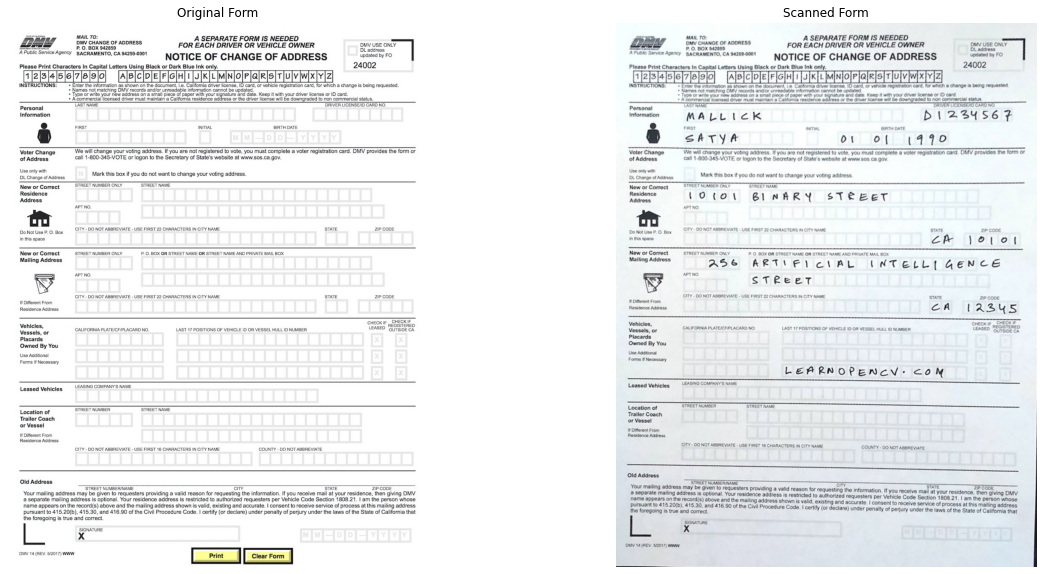

In [72]:
# Use homography to warp image
height, width, channels = img_form.shape
img_scan_reg = cv2.warpPerspective(img_scan, h, (width, height))

# Display results 
plt.figure(figsize=[20,10]); 
plt.subplot(121); plt.imshow(img_form); plt.axis('off'); plt.title("Original Form")
plt.subplot(122); plt.imshow(img_scan_reg); plt.axis('off'); plt.title("Scanned Form");